In [2]:
from seqnmf import seqnmf, plot, example_data, helpers
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter1d
from numpy.linalg import norm
from scipy.signal import convolve
from scipy.signal import decimate
import pickle
from sklearn.decomposition import PCA

import time, mne, os, ast, logging
import pandas as pd
import numpy as np
from os.path import join
from matplotlib import pyplot as plt

from expt_params import *
from functions import *



In [3]:
emu = 'EMU128'

if os.path.exists(params['outdir_edfs']):
    power_cube = np.load(params['outdir_edfs'] + '%s-power_cube.npy' % emu)
else:
    power_cube = np.load(params['outdir_edfs_WIN']  + '%s-power_cube.npy' % emu)


In [4]:
#We are struggling with the immense amount of data. Let's try smoothing the power values, then downsampling, then standardizing (below)
sigma = 20 # If og is 1000 hz, sigma is 1:1 with ms smoothing 
#Later, individual sigmas for each band and do for all bands. 
for ch in range(power_cube.shape[0]):
    if ch%10==0:print("Working on Channel #%s" % ch)
    for band in range(2, 3):
        power_cube[ch, band, :] = gaussian_filter1d(power_cube[ch, band, :], sigma=sigma, axis=-1)

Working on Channel #0
Working on Channel #10
Working on Channel #20
Working on Channel #30
Working on Channel #40
Working on Channel #50
Working on Channel #60
Working on Channel #70
Working on Channel #80
Working on Channel #90
Working on Channel #100
Working on Channel #110


In [5]:
# Now we downsample a bit...

ds_factor = 40 #1000/40 = 25 Hz downsample.
sampling_rate = int(1000/ds_factor)
decimated = decimate(power_cube[:, 2, :], ds_factor, axis=-1, ftype='fir')


In [6]:
print(decimated[:, :].shape)
print(power_cube.shape)
print(sampling_rate)
del power_cube

(119, 90000)
(119, 6, 3600000)
25


In [6]:
with open(params['outdir_edfs'] + 'decimated_alpha_%s_Hz.pkl' % sampling_rate, "wb") as f:
    pickle.dump(decimated, f)

In [8]:

### Let's do a sliding z-score on this data for each channel so that we can compare fairly across them. No high power channels will dominate motifs!

def sliding_zscore(arr, window_size):
    mean = uniform_filter1d(arr, size=window_size, mode='nearest')
    sq_mean = uniform_filter1d(arr**2, size=window_size, mode='nearest')
    std = np.sqrt(sq_mean - mean**2)
    z = (arr - mean) / std
    return z

def normalize_power(data, method='minmax'):
    """
    Normalize each neuron (row) in the data matrix individually.
    data: ndarray (neurons x time)
    """
    if method == 'minmax':
        norm_data = (data - data.min(axis=1, keepdims=True)) / (data.max(axis=1, keepdims=True) - data.min(axis=1, keepdims=True) + 1e-10)
    elif method == 'max':
        norm_data = data / (data.max(axis=1, keepdims=True) + 1e-10)
    elif method == 'zscore':
        norm_data = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-10)
    else:
        raise ValueError("Unsupported normalization method.")
    
    return norm_data

def legacy_sliding_zscore(power_cube, bin_width=1000, target_band=None):
    """
    Applies a sliding z-score normalization to a 3D power cube (channels x bands x time).
    Only normalizes a specific frequency band if target_band is specified (int).
    """
    normalized_power_cube = np.zeros_like(power_cube)
    half_bin = bin_width // 2
    n_channels, n_bands, n_times = power_cube.shape

    for ch in range(n_channels):
        print(f"Working on Channel {ch}")
        for band in range(n_bands):
            if (target_band is not None) and (band != target_band):
                continue
            for i in range(n_times):
                start = max(0, i - half_bin)
                end = min(n_times, i + half_bin)
                window = power_cube[ch, band, start:end]

                data_mean = np.mean(window)
                data_std = np.std(window)
                if data_std == 0:
                    print(f"  ⚠️ Std=0 at ch={ch}, band={band}, time={i}")
                    data_std = 1e-6  # Prevent divide-by-zero

                normalized_power_cube[ch, band, i] = (power_cube[ch, band, i] - data_mean) / data_std

    return normalized_power_cube


#Changing this to decimated...
normalized_power_cube = np.zeros_like(decimated)
bin_width = sampling_rate #if the sr is 100 hz, then 100 time points = 1 second.
#
#for ch in range(decimated.shape[0]):
#    if ch %10 ==0: print("Current Channel is %s" % ch);
#    normalized_power_cube[ch, :] = sliding_zscore(decimated[ch, :], bin_width)
"""
#For power cube:
normalized_power_cube = np.zeros_like(power_cube)
bin_width = 1000  # Must be odd to center the window (if not, close enough is fine) 

for ch in range(power_cube.shape[0]): #power_cube.shape[0]cha
    print(f"Channel {ch}")
    for band in range(power_cube.shape[1]):
        normalized_power_cube[ch, band, :] = sliding_zscore(power_cube[ch, band, :], bin_width)
"""
#Legacy, works but is extremely slow computationally.
#print(np.allclose(test_normPC[0, 0, 10000:20000], normalized_power_cube[0, 0, 10000:20000], atol=1e-5))  # Should be True


'\n#For power cube:\nnormalized_power_cube = np.zeros_like(power_cube)\nbin_width = 1000  # Must be odd to center the window (if not, close enough is fine) \n\nfor ch in range(power_cube.shape[0]): #power_cube.shape[0]cha\n    print(f"Channel {ch}")\n    for band in range(power_cube.shape[1]):\n        normalized_power_cube[ch, band, :] = sliding_zscore(power_cube[ch, band, :], bin_width)\n'

In [9]:
normalized_power_cube = normalize_power(decimated, method='minmax')

In [8]:
#FOR DECIM, makes sure all values are positive

for ch in range(normalized_power_cube.shape[0]):
    if ch%10==0: print(ch)
    min_val = np.min(normalized_power_cube[ch, :])
    normalized_power_cube[ch, :] -= min_val



0
10
20
30
40
50
60
70
80
90
100
110


In [19]:
#FOR DECIM
start_time = time.time()

K = 28
L = 98 #980 ms
Lambda = 0.0005

[W, H, cost, loadings, power] = seqnmf(normalized_power_cube, K, L=L, Lambda=Lambda)

end_time = time.time()
runtime_seconds = end_time - start_time
print("Runtime was %s seconds" %runtime_seconds)

Runtime was 16816.81442117691 seconds


In [29]:
#WRITING IT
with open("C:\\Users\\Kamron\\Documents\\PhD\\sEEG_processing\\DATA\\motif_test.pkl", "wb") as f:
    pickle.dump([W, H, cost, loadings, power], f)

In [16]:
#READING IT
with open(params['outdir'] + 'motif_test.pkl', "rb") as f:
    W, H, cost, loadings, power = pickle.load(f)

In [68]:
#Our next step will be to reconstruct the data,
#Then depict how much variance each motif captures and in total all the motifs
#Then we should practice visualizing dynamics of motifs with brain images
##THENN!! We will have all of the tools to 'evaluate' the motifs well, so we can run this with new parameters to find an optimal solution or something.

In [53]:
def reconstruct(W, H):
    """
    Reconstructs the original data matrix X_hat from the factors W and H.
    
    Parameters:
    W (numpy.ndarray): The neuron basis functions (NxKxL).
    H (numpy.ndarray): The timecourses for each factor (KxT).
    
    Returns:
    X_hat (numpy.ndarray): The reconstructed data matrix.
    """
    # Get the dimensions of W and H
    N, K, L = W.shape
    _, T = H.shape
    
    # Zero-pad H by L on both sides, prevents edge artifacts
    H_padded = np.pad(H, ((0, 0), (L, L)), mode='constant', constant_values=0)
    # Update T for the padded version
    T_padded = T + 2 * L #Time points add 2 lengths of L
    
    # Initialize X_hat as a zero matrix
    X_hat = np.zeros((N, T_padded))
    
    # Perform the reconstruction with the convolution-like operation
    for tau in range(L):
        # Shift H by tau and multiply with corresponding W[:, :, tau]
        shifted_H = np.roll(H_padded, shift=(0, tau), axis=1)
        X_hat += np.dot(W[:, :, tau], shifted_H)
    
    # Crop the extra zero-padding at the edges
    X_hat = X_hat[:, L:T_padded - L]
    
    return X_hat

def compute_pev(X_hat, normalized_power_cube):
    """
    Compute the Percent Explained Variance (PEV) between original and reconstructed data.
    
    Parameters:
        X_hat (np.ndarray): Reconstructed data (neurons x time)
        normalized_power_cube (np.ndarray): Original data (neurons x time)

    Returns:
        float: Percent Explained Variance (PEV)
    """
    # Ensure the shapes match
    if X_hat.shape != normalized_power_cube.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Flatten arrays to compute global spatiotemporal variance
    original = normalized_power_cube.flatten()
    reconstructed = X_hat.flatten()
    
    # Compute variances
    var_original = np.var(original)
    var_reconstructed = np.var(reconstructed)
    
    # Compute PEV
    pev = 100 * (1 - ((var_original - var_reconstructed) / var_original))
    
    return pev

def compute_pev_individually(W, H, original_data):
    variance_motif_array = []
    for mc in range(0, W.shape[1]):
        print("Working on Motif # %s" % mc+1)
        single_motif_data = helpers.reconstruct(W[:, mc:mc+1, :], H[mc:mc+1, :])
        variance_motif_array.append(compute_pev(single_motif_data, original_data))

    return variance_motif_array


In [69]:
X_hat = helpers.reconstruct(W, H)

In [70]:
#TOTAL VARIANCE EXPLAINED
variance_original = np.var(normalized_power_cube, axis=1).sum()

# Calculate the variance of the reconstructed data (along time axis, axis=1)
variance_reconstructed = np.var(X_hat, axis=1).sum()

print("Original Variance: %s" % variance_original)
print("Reconstructed Variance %s" % variance_reconstructed)
print("Percent Explained: %s%%" % round((variance_reconstructed/variance_original*100), 2))


Original Variance: 110.013695320658
Reconstructed Variance 17.10121184725215
Percent Explained: 15.54%


In [73]:
variance_explained = compute_pev(X_hat, normalized_power_cube)
variance_explained

16.062111740649275

In [91]:
single_motif_variance = compute_pev_individually(W, H, normalized_power_cube)

Working on Motif # 0
Working on Motif # 1
Working on Motif # 2
Working on Motif # 3
Working on Motif # 4
Working on Motif # 5
Working on Motif # 6
Working on Motif # 7
Working on Motif # 8
Working on Motif # 9
Working on Motif # 10
Working on Motif # 11
Working on Motif # 12
Working on Motif # 13
Working on Motif # 14
Working on Motif # 15
Working on Motif # 16
Working on Motif # 17
Working on Motif # 18
Working on Motif # 19
Working on Motif # 20
Working on Motif # 21
Working on Motif # 22
Working on Motif # 23
Working on Motif # 24
Working on Motif # 25
Working on Motif # 26
Working on Motif # 27


In [82]:
#Let's systematically test different configurations!
def get_next_run_dir(base_dir):
    os.makedirs(base_dir, exist_ok=True)
    runs = [d for d in os.listdir(base_dir) if d.startswith("run_")]
    run_ids = [int(d.split("_")[1]) for d in runs if d.split("_")[1].isdigit()]
    next_id = max(run_ids + [0]) + 1
    run_dir = os.path.join(base_dir, f"run_{next_id:03d}")
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

def save_seqnmf_results_pickle(W, H, cost, loadings, power, outpath):
    results = {
        "W": W,
        "H": H,
        "cost": cost,
        "loadings": loadings,
        "power": power
    }
    with open(os.path.join(outpath, "seqnmf_results.pkl"), "wb") as f:
        pickle.dump(results, f)

def load_seqnmf_results_pickle(run_dir):
    with open(os.path.join(run_dir, "seqnmf_results.pkl"), "rb") as f:
        return pickle.load(f)

def setup_logger(log_path):
    logger = logging.getLogger(str(log_path))
    logger.setLevel(logging.INFO)
    if not logger.handlers:  # Prevents adding multiple handlers
        handler = logging.FileHandler(log_path)
        handler.setFormatter(logging.Formatter('%(asctime)s - %(message)s'))
        logger.addHandler(handler)
    return logger

def run_and_log_seqnmf(data, test_data = None, K=10, L=10, Lambda=0.0005, lambda_OrthH=1, base_outdir=''):
    run_dir = get_next_run_dir(base_outdir)
    log_file = os.path.join(run_dir, "seqnmf_run.log")
    logger = setup_logger(log_file)

    start_time = time.time()
    logger.info(f"Running seqnmf with K={K}, L={L}, Lambda={Lambda}, lambda_OrthH={lambda_OrthH}")

    # Run seqnmf (replace this with your implementation)
    W, H, cost, loadings, power = seqnmf(data, K, L=L, Lambda=Lambda, lambda_OrthH=lambda_OrthH)
    M_test = np.ones_like(test_data)  # All ones = use all data

    H_test_init = np.random.rand(K, test_data.shape[1]) #motifs x timepoints
    W_test, H_test = seqnmf(X=test_data, W_init=W, H_init=H_test_init, K=K, L=L, W_fixed=True, Lambda=Lambda, lambda_OrthH=lambda_OrthH, M = M_test) #Need to validate this works then actually get the PEV from it

    pev = total_variance_explained(data, W, H)

    runtime = time.time() - start_time
    logger.info(f"Runtime: {runtime:.2f} seconds")
    logger.info(f"Cost: {cost}")
    logger.info(f"Loadings: {loadings}")
    logger.info(f"Power: {power}")
    logger.info(f"Total Variance Explained: {pev}")

    save_seqnmf_results_pickle(W, H, cost, loadings, power, run_dir)

    return W, H, cost, loadings, power, runtime, run_dir

def total_variance_explained(original_data, W, H):
    variance_original = np.var(original_data, axis=1).sum()

    # Calculate the variance of the reconstructed data (along time axis, axis=1)
    X_hat = helpers.reconstruct(W, H)
    variance_reconstructed = np.var(X_hat, axis=1).sum()

    return round((variance_reconstructed/variance_original*100), 2)

# Test with your parameters
"""K = 10
L = 25  # 980 ms
Lambda = 0.0005
lambda_OrthH = 1

W, H, cost, loadings, power, runtime_seconds, run_dir = run_and_log_seqnmf(normalized_power_cube[0:5, :], K, L, Lambda, lambda_OrthH, 'f:\\LOGS\\SEQNMF\\')"""

"K = 10\nL = 25  # 980 ms\nLambda = 0.0005\nlambda_OrthH = 1\n\nW, H, cost, loadings, power, runtime_seconds, run_dir = run_and_log_seqnmf(normalized_power_cube[0:5, :], K, L, Lambda, lambda_OrthH, 'f:\\LOGS\\SEQNMF\\')"

In [77]:
# ALTERNATING DATA FOR TRAIN AND TEST!
num_timepoints = normalized_power_cube.shape[1]
#Find num_timepoints that equals a 2 minute block!
two_min = sampling_rate * 120 
two_min = sampling_rate * 120
train_blocks, test_blocks = [], []

for idx, i in enumerate(range(0, normalized_power_cube.shape[1] - two_min + 1, two_min)):
    block = normalized_power_cube[:, i:i+two_min]
    (train_blocks if idx % 2 == 0 else test_blocks).append(block)

training_data = np.concatenate(train_blocks, axis=1) #AXIS =1 to ensure you combine over time and not channels
testing_data = np.concatenate(test_blocks, axis=1) #AXIS =1 to ensure you combine over time and not channels

(5, 40, 40)

In [83]:
Ks = [5, 15, 25, 40]
Ls = [5, 15, 25, 40]
Lambdas = [0.0001, 0.0005, 0.001, 0.01]
lambda_OrthHs = [0, 0.5, 1, 2]

for K in Ks:
    print("Current K: %s" %K)
    for L in Ls:
        for Lambda in Lambdas:
            for lambda_OrthH in lambda_OrthHs:
                W, H, cost, loadings, power, runtime_seconds, run_dir = run_and_log_seqnmf(
                    training_data[0:2, :], testing_data[0:2, :],
                    K, L, Lambda, lambda_OrthH,
                    'f:\\LOGS\\SEQNMF\\TRAIN\\'
                )

                


Current K: 5


IndexError: boolean index did not match indexed array along axis 1; size of axis is 45010 but size of corresponding boolean axis is 45000

In [30]:
normalized_power_cube.shape

(119, 90000)

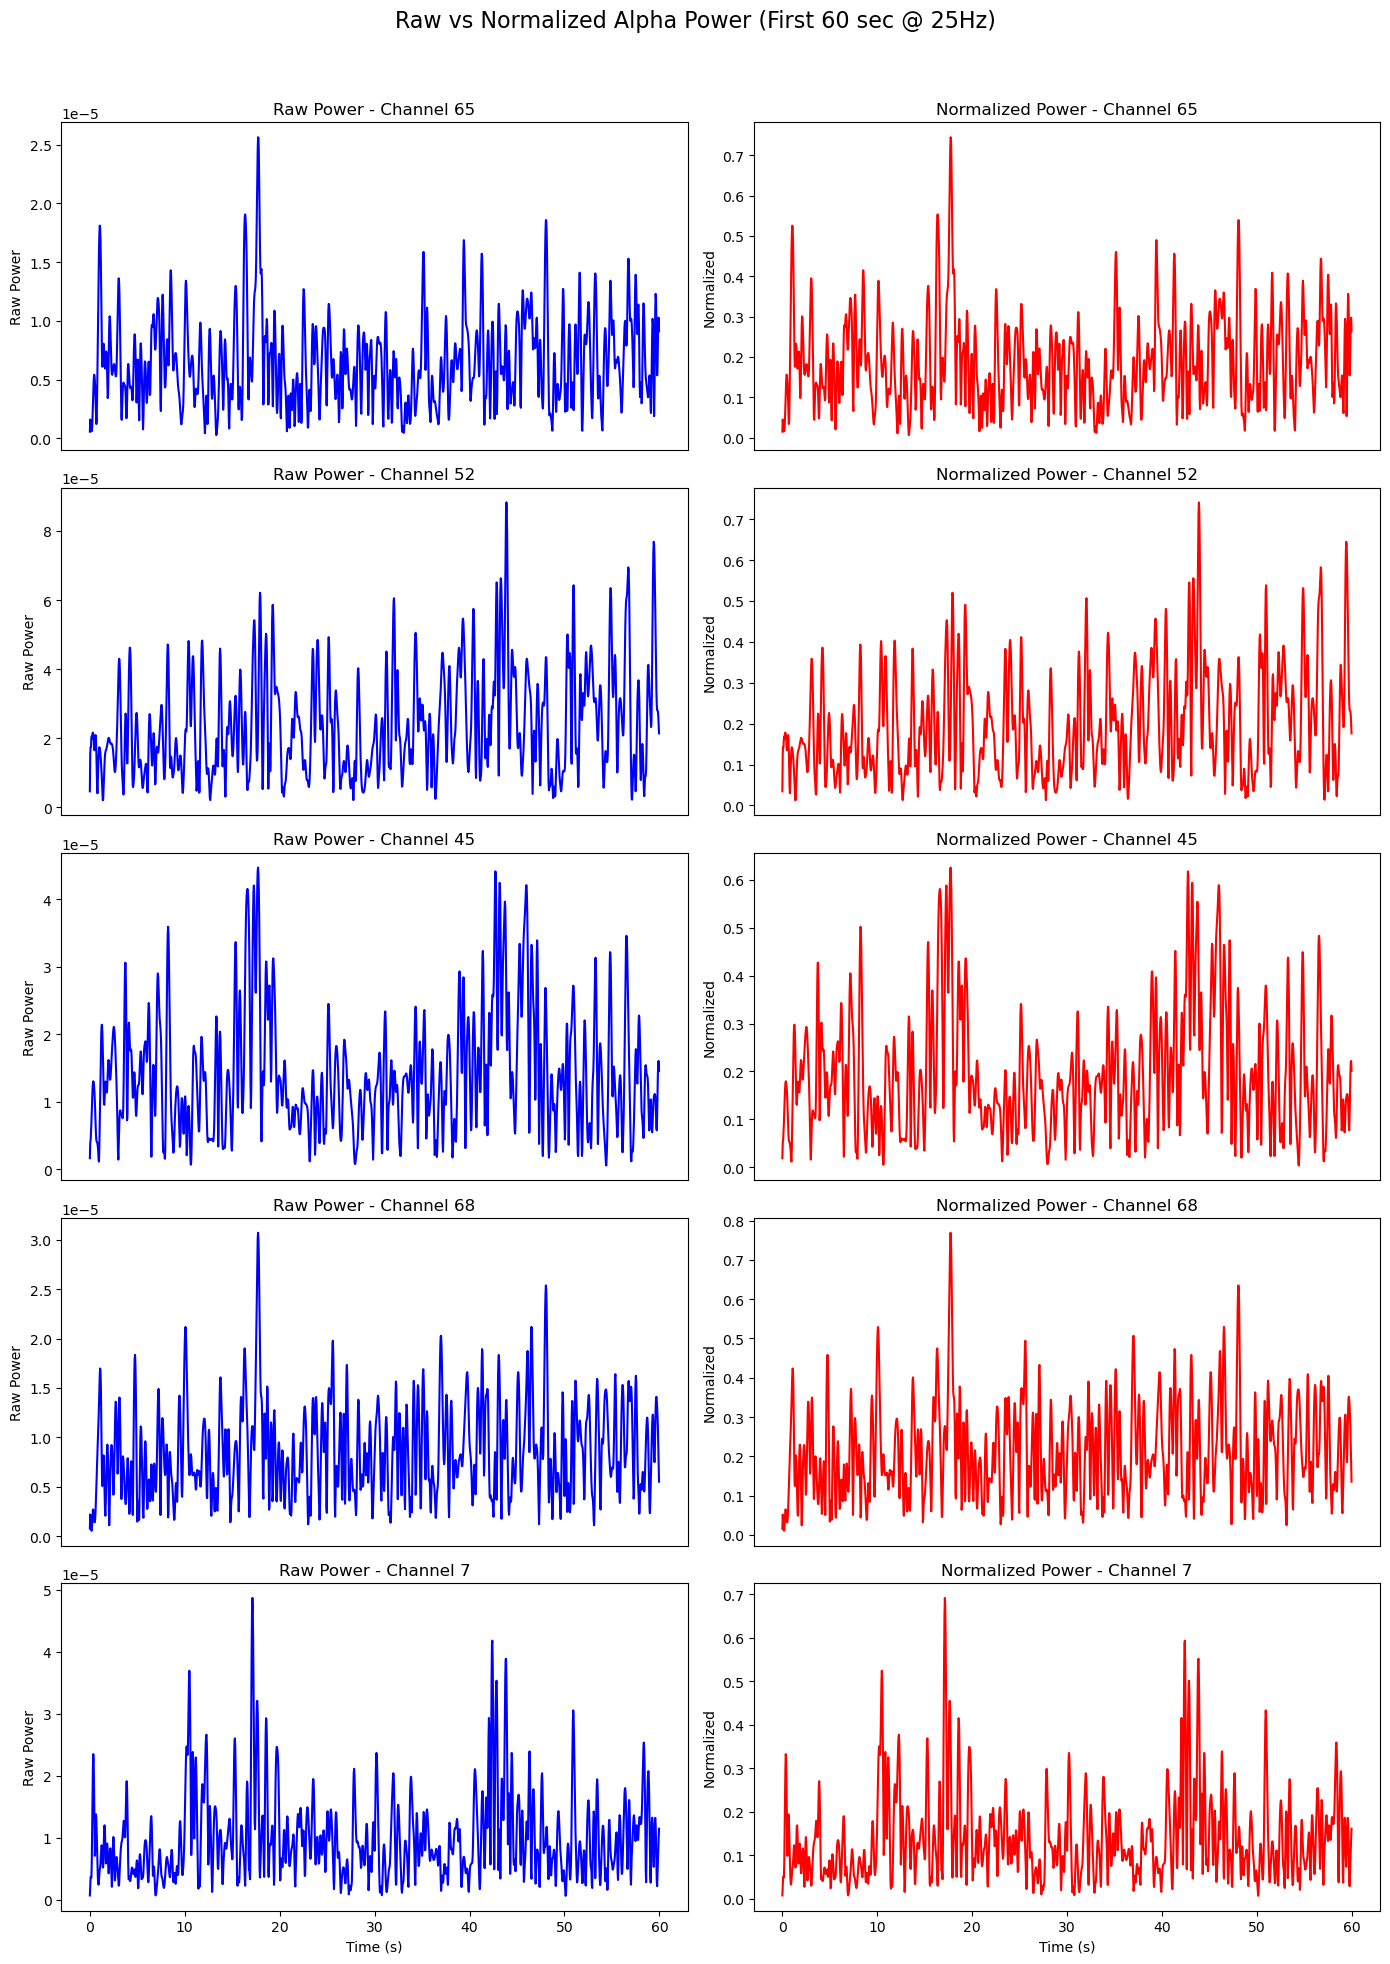

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_power_cube(data, normalized_data, sampling_rate=25, n_channels=5, duration_sec=60):
    """
    Plot raw and normalized power on separate subplots per channel to validate downsampling and normalization.

    Parameters:
    - data: 2D array (channels x time) of raw power
    - normalized_data: 2D array (channels x time) of normalized data
    - sampling_rate: Hz
    - n_channels: number of random channels to plot
    - duration_sec: duration (in seconds) to show
    """
    n_total_channels, n_total_timepoints = data.shape
    n_timepoints = int(duration_sec * sampling_rate)
    t = np.arange(n_timepoints) / sampling_rate  # time in seconds

    selected_channels = np.random.choice(n_total_channels, size=n_channels, replace=False)

    plt.figure(figsize=(14, 4 * n_channels))

    for i, ch in enumerate(selected_channels):
        # Raw power
        plt.subplot(n_channels, 2, 2 * i + 1)
        plt.plot(t, data[ch, :n_timepoints], color='blue')
        plt.title(f"Raw Power - Channel {ch}")
        plt.ylabel("Raw Power")
        if i == n_channels - 1:
            plt.xlabel("Time (s)")
        else:
            plt.xticks([])

        # Normalized power
        plt.subplot(n_channels, 2, 2 * i + 2)
        plt.plot(t, normalized_data[ch, :n_timepoints], color='red')
        plt.title(f"Normalized Power - Channel {ch}")
        plt.ylabel("Normalized")
        if i == n_channels - 1:
            plt.xlabel("Time (s)")
        else:
            plt.xticks([])

    plt.suptitle(f"Raw vs Normalized Alpha Power (First {duration_sec} sec @ {sampling_rate}Hz)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_normalized_power_cube(decimated, normalized_power_cube)

In [46]:
#Let's compare this to pca
pca = PCA(n_components=K)  # Using the same # of components as motifs
pca.fit(normalized_power_cube)

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Total variance explained by all the components
total_explained_variance = np.sum(explained_variance_ratio)

print(f"Total Explained Variance by PCA: {total_explained_variance * 100:.2f}%")

print("Explained variance ratio by each component:")
print(explained_variance_ratio)

Total Explained Variance by PCA: 73.85%
Explained variance ratio by each component:
[0.10481832 0.07862738 0.05167976 0.04419323 0.03849501 0.03841366
 0.03229762 0.02736774 0.02665189 0.02474833 0.02355038 0.02227163
 0.02053392 0.01998354 0.01779475 0.01672864 0.01617235 0.01489465
 0.01441063 0.01377233 0.01309203 0.01286143 0.01221916 0.01138723
 0.01100932 0.01041387 0.01009348 0.01004466]


28